# Machine Learning Exercise 17
# Timeseries anomaly detection using an Autoencoder

Exercise inspired by https://github.com/pavithrasv

This exercise shows the use of 1D Convolutional Autoencoder to detect anonalies in a 1D signal. It will also show examples of data generation.

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## Load the data

We will use the [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) dataset. It provides artifical
timeseries data containing labeled anomalous periods of behavior. Data are
ordered, timestamped, single-valued metrics.

We will use the `art_daily_small_noise.csv` file for training and the
`art_daily_jumpsup.csv` file for testing. The simplicity of this dataset
allows us to demonstrate anomaly detection effectively.

In [ ]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

## Visualize the data

In [ ]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


### Timeseries data without anomalies

We will use the following data for training.

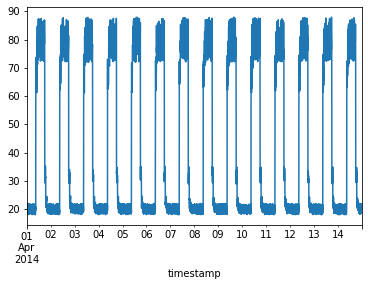

In [ ]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

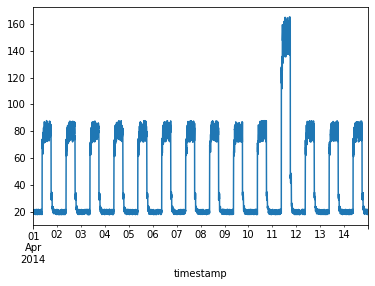

In [ ]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

## Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the training data. Each bunch of data is separated by `TIME_DELTA` steps. When `TIME_DELTA = TIME_STEPS` there will be no overlapping in the produced data.

Note: you can change `TIME_DELTA` for the AE part.

In [ ]:
TIME_STEPS = 288
TIME_DELTA = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(0,len(values) - time_steps+1, TIME_DELTA):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (14, 288, 1)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ], name = "AE"
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae")
print("Input: %s" %str(x_train.shape))
model.summary()

Input: (14, 288, 1)
Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                  

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.9676
Epoch 2/100
1/1 [==============================] - 0s 22ms/step - loss: 0.9521
Epoch 3/100
1/1 [==============================] - 0s 22ms/step - loss: 0.9387
Epoch 4/100
1/1 [==============================] - 0s 29ms/step - loss: 0.9251
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 0.9083
Epoch 6/100
1/1 [==============================] - 0s 23ms/step - loss: 0.8909
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 0.8687
Epoch 8/100
1/1 [==============================] - 0s 23ms/step - loss: 0.8409
Epoch 9/100
1/1 [==============================] - 0s 22ms/step - loss: 0.8053
Epoch 10/100
1/1 [==============================] - 0s 21ms/step - loss: 0.7688
Epoch 11/100
1/1 [==============================] - 0s 26ms/step - loss: 0.7221
Epoch 12/100
1/1 [==============================] - 0s 24ms/step - loss: 0.6618
Epoch 13/100
1/1 [==============================] -

Let's plot training and validation loss to see how the training went.

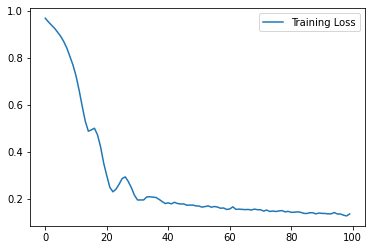

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


1/1 [==============================] - 0s 209ms/step


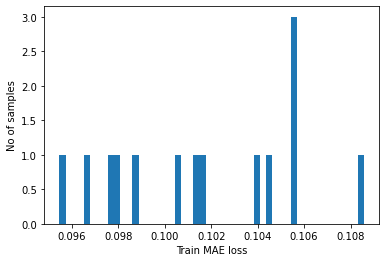

Reconstruction error threshold:  0.11334863568507282


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.mean(train_mae_loss) + 3*np.std(train_mae_loss)

print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

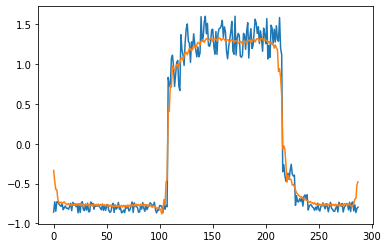

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Prepare test data

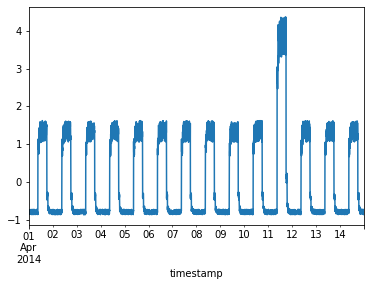

Test input shape:  (14, 288, 1)
1/1 [==============================] - 0s 20ms/step


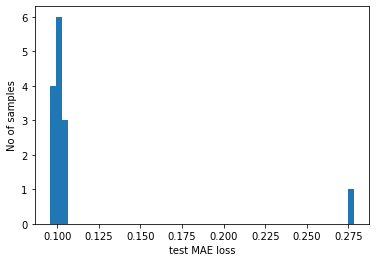

Number of anomaly samples:  1
Indices of anomaly samples:  (array([10]),)


In [ ]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data.

Let's overlay the anomalies on the original test data plot.

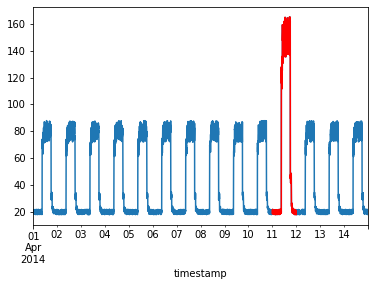

In [ ]:
w = np.where(anomalies)

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    a = (data_idx)//TIME_DELTA
    if a in w[0]:
        anomalous_data_indices.append(data_idx)

df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

# GAN

Let us use a GAN to generate data samples.

GAN is trained with only normal samples and will generate new normal samples.

In [ ]:
# Use also normal samples from the test set
x_train = np.vstack((x_train,x_test[0:9]))
x_train = np.vstack((x_train,x_test[11:13]))

print(x_train.shape)

(25, 288, 1)


## Model

Define the GAN model.


In [ ]:
print("\nInput: %s\n" %str(x_train.shape))

discriminator = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu", name="Dfeat"
        ),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ], name = "D"
)
discriminator.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()


l = discriminator.get_layer(name="Dfeat")
print("\nDiscriminator feature layer: %s" %str(l.output_shape))


# Latent space dimension for generator
latent_dim = l.output_shape[1]
latent_shape = (latent_dim,)
print("\nLatent space: %s\n" %str(latent_shape))
n_nodes = l.output_shape[1] * l.output_shape[2]

generator = keras.Sequential(
    [
        layers.Dense(n_nodes, input_shape=latent_shape, activation="relu"),
        layers.Reshape((72,16)),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ], name = "G"
)
generator.summary()

# store a noisy sample generated before training
noise = np.random.normal(0, 1, (1, latent_dim))
noise_sample = generator.predict(noise)


# The combined GAN model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity
gan = keras.Sequential(name="GAN")
gan.add(layers.Input(shape=latent_shape))
gan.add(generator)
gan.add(discriminator)
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001))
gan.summary()

# Training epochs counter
epoch=0



Input: (25, 288, 1)

Model: "D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 Dfeat (Conv1D)              (None, 72, 16)            3600      
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 1)                 1153      
                                                                 
Total params: 5,009
Trainable params: 5,009
Non-trainable params: 0
_________________________________________________________________

Discriminator feature layer: (None, 72, 

## Train

Define the GAN training function

In [ ]:
def train(epochs, batch_size=32, save_interval=100):
    global epoch

    half_batch = int(batch_size / 2)

    last_epoch = epoch + epochs

    while epoch < last_epoch:

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of samples
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        samples = x_train[idx]

        # Generate a half batch of new samples
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        gen_samples = generator.predict(noise)

        # Train the discriminator
        X, y = np.vstack((samples, gen_samples)), np.vstack((np.ones((half_batch, 1)), np.zeros((half_batch, 1))))
        d_loss = discriminator.train_on_batch(X, y)


        # ---------------------
        #  Train Generator
        # ---------------------
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        valid_y = np.array([1] * batch_size)

        # Train the generator
        g_loss = gan.train_on_batch(noise, valid_y)

        epoch += 1

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            # Plot the progress                
            print ( "%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            if g_loss<1.0 and d_loss[1]>0.4 and d_loss[1]<0.6:
                break


Now train the model.

Train until you get D acc around 50% and G loss < 1.0

In [ ]:
train(1000, save_interval=100)

1/1 [==============================] - 0s 22ms/step
100 [D loss: 0.008566, acc: 100.00%] [G loss: 4.510943]
1/1 [==============================] - 0s 21ms/step
200 [D loss: 0.004972, acc: 100.00%] [G loss: 5.051140]
1/1 [==============================] - 0s 22ms/step
300 [D loss: 0.030005, acc: 100.00%] [G loss: 12.621715]
1/1 [==============================] - 0s 22ms/step
400 [D loss: 0.023659, acc: 100.00%] [G loss: 4.561102]
1/1 [==============================] - 0s 23ms/step
500 [D loss: 0.263054, acc: 100.00%] [G loss: 2.001307]
1/1 [==============================] - 0s 26ms/step
600 [D loss: 0.584220, acc: 75.00%] [G loss: 1.592322]
1/1 [==============================] - 0s 22ms/step
700 [D loss: 0.125640, acc: 100.00%] [G loss: 3.173184]
1/1 [==============================] - 0s 23ms/step
800 [D loss: 1.888765, acc: 3.12%] [G loss: 0.213726]
1/1 [==============================] - 0s 20ms/step
900 [D loss: 0.883433, acc: 28.12%] [G loss: 1.258115]
1/1 [==========================

## Generate

Generate a new 1D signal formed by

    2 normal chunks
    1 chunk generated by the AE
    1 chink generated by the untrained GAN
    1 chunk generated by the trained GAN
    2 normal chunks


(2016, 1)


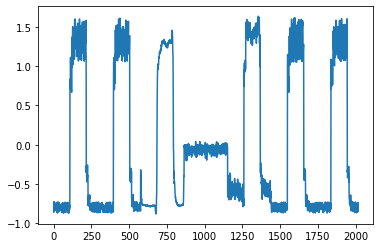

In [ ]:
# Generate new time series
noise = np.random.normal(0, 1, (1, latent_dim))
new_sample = generator.predict(noise)

y = x_train[0]
y = np.vstack((y,x_train[1]))
y = np.vstack((y,x_train_pred[0]))
y = np.vstack((y,noise_sample[0]))
y = np.vstack((y,new_sample[0]))
y = np.vstack((y,x_train[2]))
y = np.vstack((y,x_train[3]))

print(y.shape)

# Plot the new sample
plt.plot(y)
plt.show()

## Test 

Test generated sample for anomaly detection.

Use AE to check for anomalies in the new generated 1D signal.

New sample shape:  (7, 288, 1)


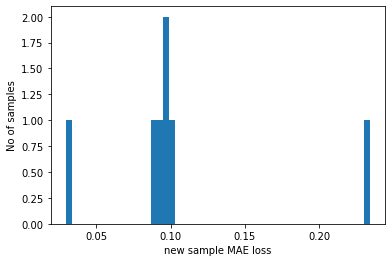

Number of anomaly samples:  1
Indices of anomaly samples:  (array([3]),)


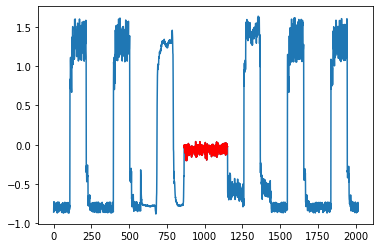

In [ ]:
# Create sequences from new sample
y_test = create_sequences(y)
print("New sample shape: ", y_test.shape)

y_pred = model.predict(y_test)
y_mae_loss = np.mean(np.abs(y_pred - y_test), axis=1)
y_mae_loss = y_mae_loss.reshape((-1))

plt.hist(y_mae_loss, bins=50)
plt.xlabel("new sample MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
y_anomalies = y_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(y_anomalies))
print("Indices of anomaly samples: ", np.where(y_anomalies))


w = np.where(y_anomalies)

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(y) - TIME_STEPS + 1):
    a = (data_idx)//TIME_DELTA
    if a in w[0]:
        anomalous_data_indices.append(data_idx)

y = pd.DataFrame(y)
y_subset = y.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
plt.plot(y)
y_subset.plot(legend=False, ax=ax, color="r")
plt.show()
